In [35]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
reload(nml)

def get_Rij(fname):
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats])
    R11 = dat[:,0]
    R12 = dat[:,1]
    R13 = dat[:,2]
    R22 = dat[:,3]
    R23 = dat[:,4]
    R33 = dat[:,5]
    return R11,R12,R13,R22,R23,R33

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr7/1024x1448x512/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr_7/1024x1448x512/'

Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"*Rij*")
flist.sort()
print([f.split('/')[-1] for f in flist])

Params for this grid:
	N = 1024.0x1448.0x512.0
	L = 150.0x200.0x75.0
['shearlayer_Rij_0010.dat', 'shearlayer_Rij_0011.dat', 'shearlayer_Rij_0030.dat', 'shearlayer_Rij_0031.dat', 'shearlayer_Rij_0032.dat', 'shearlayer_Rij_0033.dat', 'shearlayer_Rij_0034.dat', 'shearlayer_Rij_0035.dat', 'shearlayer_Rij_0036.dat', 'shearlayer_Rij_0037.dat', 'shearlayer_Rij_0038.dat', 'shearlayer_Rij_0039.dat', 'shearlayer_Rij_0040.dat']


Text(0.5,0,'$y$')

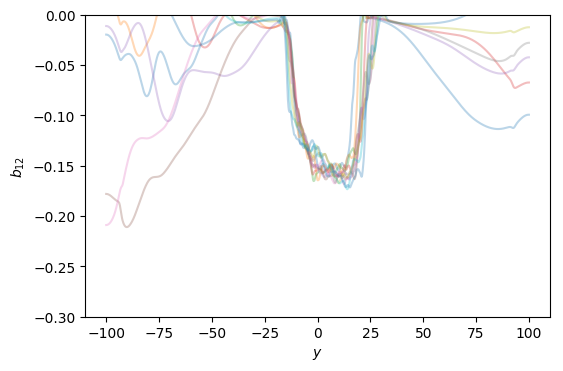

In [26]:
# Anisotropy profiles

fig = plt.figure(dpi=100)

flist_plot = flist[2:]
for fname in flist_plot:
    tID = fname.split('/')[-1]
    tID = tID.split('_')[-1]
    tID = int(tID.split('.')[0])
    time = nml.read_time(directory,tID)
    
    R11,R12,R13,R22,R23,R33 = get_Rij(fname)
    b12 = R12/(R11+R22+R33)
    plt.plot(y,b12,alpha=0.3,label='t = %i'%time)
    
plt.ylim([-0.3,0])
plt.ylabel('$b_{12}$')
plt.xlabel('$y$')
# plt.legend()

/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/1024x1448x512/
b12 = [0.144922322845,0.0107600739324]


Text(0.5,0,'$y$')

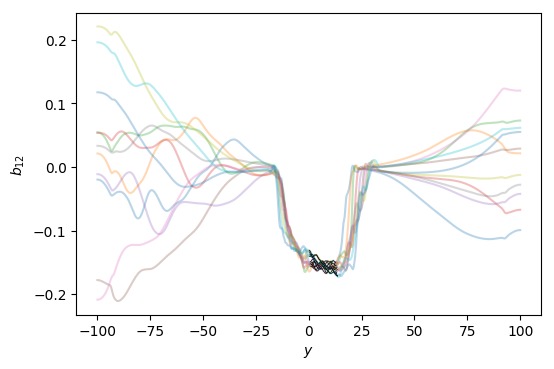

In [31]:
# Uncertainty:
fig = plt.figure(dpi=100)

def growth_rates(filename_prefix):
    fname = filename_prefix+'growth.dat'
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=3
    dat = np.reshape(dat,[n/nstats,nstats])
    time = dat[:,0]
    dtheta = dat[:,1]
    domega = dat[:,2]
    return time,dtheta,domega 

time,dtheta,rate = growth_rates(directory+'/shearlayer_')

flist_plot = flist[2:]
b12_array = [];
for fname in flist_plot:
    tID = fname.split('/')[-1]
    tID = tID.split('_')[-1]
    tID = int(tID.split('.')[0])
    t = nml.read_time(directory,tID)

    # Get the range to take mean:
    it = np.argmin(abs(time-t))
    iy = Ny/2-np.argmin(abs(y+dtheta[it]*2))
    
    R11,R12,R13,R22,R23,R33 = get_Rij(fname)
    b12 = R12/(R11+R22+R33)
    plt.plot(y,b12,alpha=0.3,label='t = %i'%t)    
    shift = 50
    plt.plot(y[Ny/2-iy+shift:Ny/2+iy+shift],b12[Ny/2-iy+shift:Ny/2+iy+shift],'k',linewidth=0.5)    
    
    b12_array = np.concatenate((b12_array,b12[Ny/2-iy:Ny/2+iy]))

print(directory)
print('b12 = [{},{}]'.format(abs(np.mean(b12_array)),np.std(b12_array)))
plt.ylabel('$b_{12}$')
plt.xlabel('$y$')
# plt.legend()

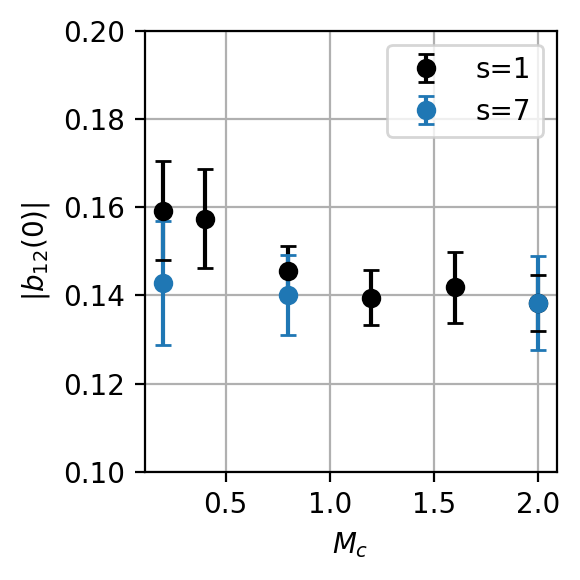

In [34]:

b12 = {#PadeOps
    0.2: [0.159173974073, 0.0112351050727], #1024x1448
    0.4: [0.157403592666, 0.0112674417175], #1024x1448
    0.8: [0.145644404576, 0.00548395484344], #1024x1448
    1.2: [0.139516459053, 0.00621334877187], #1024x1448
    1.6: [0.141869005877, 0.00807345268658], #1024x1448
    2.0: [0.138281126405, 0.00630199436211] #1024x1448
}
b12_rr7 = {#PadeOps rr7
    0.2: [0.140568278182,0.00900407289981],
    0.8: [0.137215690959, 0.00682633764764],
    2.0: [0.140007263313, 0.00504630250565]}
b12_rr_7 = {#PadeOps rr_7
    0.2: [0.144922322845,0.0107600739324],
    0.8: [0.142935288739, 0.00604788173848],
    2.0: [0.136430056814, 0.00943156571654]}

def merge_dicts(old1,old2):
    new = {}
    for i in range(3):
        key = old1.keys()[i]
        v1 = old1.values()[i][0]
        v2 = old2.values()[i][0]
        e1 = old1.values()[i][1]
        e2 = old2.values()[i][1]
        err = (e1**2+e2**2)**0.5
        new[key] = [(v1+v2)/2., err]
    return new

rr = merge_dicts(b12_rr7,b12_rr_7)

fig = plt.figure(figsize=(3,3),dpi=200)
plt.errorbar(b12.keys(),[x[0] for x in b12.values()], yerr=[x[1] for x in b12.values()],fmt='ko',label='s=1',capsize=3)
# plt.errorbar([k-0.02 for k in b12_rr7.keys()],[x[0] for x in b12_rr7.values()],yerr=[x[1] for x in b12_rr7.values()],fmt='o',label='s=7',capsize=3)
# plt.errorbar([k+0.02 for k in b12_rr_7.keys()],[x[0] for x in b12_rr_7.values()],yerr=[x[1] for x in b12_rr_7.values()],fmt='o',label='s=1/7',capsize=3)
plt.errorbar(rr.keys(),[x[0] for x in rr.values()], yerr=[x[1] for x in rr.values()],fmt='o',label='s=7',capsize=3)

plt.grid(True)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$|b_{12}(0)|$')
plt.ylim([0.1,0.2])
plt.legend()
plt.tight_layout()
plt.savefig('/home/kmatsuno/ShearLayer_img/b12.png',dpi=200, bbox_inches='tight')


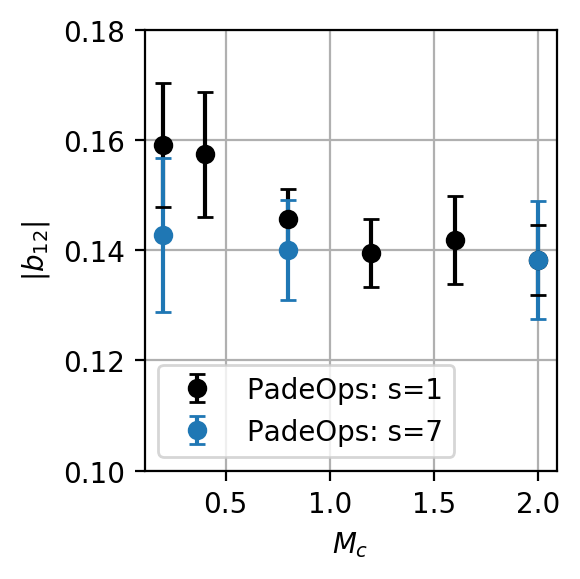

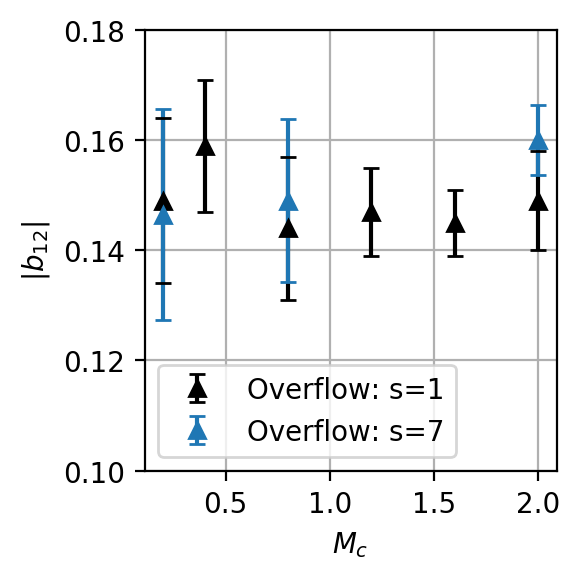

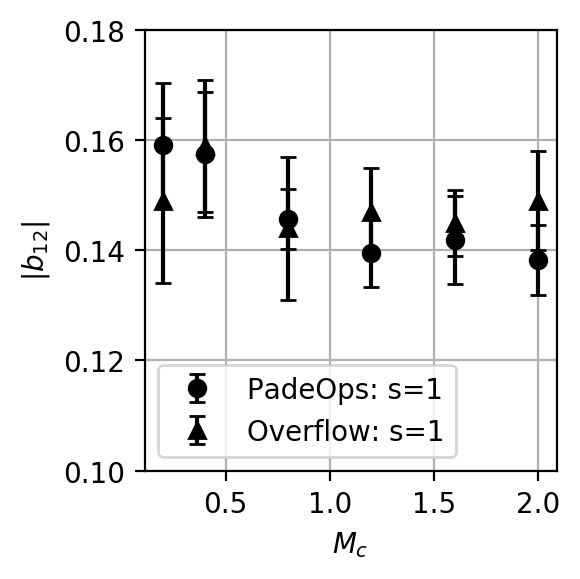

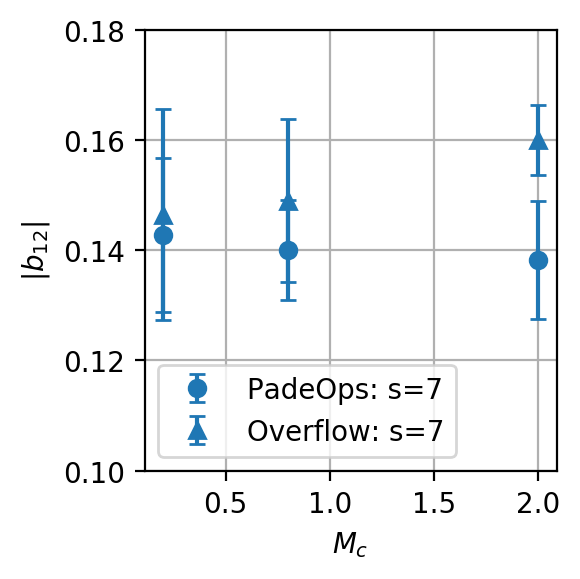

In [43]:
# OVERFLOW 
b12_ovf = {
    0.2: [0.149, 0.015],
    0.4: [0.159, 0.012], 
    0.8: [0.144, 0.013], 
    1.2: [0.147, 0.008],
    1.6: [0.145, 0.006],
    2.0: [0.149, 0.009]}
b12_rr7_ovf = {
    0.2: [0.149, 0.012],
    0.8: [0.15, 0.007],
    2.0: [0.162, 0.005]}
b12_rr_7_ovf = {
    0.2: [0.144, 0.015],
    0.8: [0.148, 0.013],
    2.0: [0.158, 0.004]}

def make_nice():
    plt.legend()
    plt.grid(True)
    plt.xlabel(r'$M_c$')
    plt.ylabel(r'|$b_{12}$|')
    plt.ylim([0.1,0.18])
    plt.tight_layout()
    
Lvv = b12
Lvv_rr_7 = b12_rr_7
Lvv_rr7 = b12_rr7
Lvv_ovf = b12_ovf
Lvv_rr_7_ovf = b12_rr_7_ovf
Lvv_rr7_ovf = b12_rr7_ovf

rr_ovf = merge_dicts(Lvv_rr7_ovf,Lvv_rr_7_ovf)

DPI=200 
prefix = '/home/kmatsuno/Ovf_compare/b12_'

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(Lvv.keys(),[x[0] for x in Lvv.values()], yerr=[x[1] for x in Lvv.values()],fmt='ko',label='PadeOps: s=1',capsize=3)
# plt.errorbar(Lvv_rr_7.keys(),[x[0] for x in Lvv_rr_7.values()],yerr=[x[1] for x in Lvv_rr_7.values()],fmt='o',label='PadeOps: s=1/7',color='C0',capsize=3)
# plt.errorbar(Lvv_rr7.keys(),[x[0] for x in Lvv_rr7.values()], yerr=[x[1] for x in Lvv_rr7.values()],fmt='o',label='PadeOps: s=7',color='C1',capsize=3)
plt.errorbar(rr.keys(),[x[0] for x in rr.values()], yerr=[x[1] for x in rr.values()],fmt='o',label='PadeOps: s=7',capsize=3)
make_nice()
plt.savefig(prefix+'padeops.png',dpi=DPI, bbox_inches='tight')

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(Lvv_ovf.keys(),[x[0] for x in Lvv_ovf.values()],yerr=[x[1] for x in Lvv_ovf.values()],fmt='k^',label='Overflow: s=1',capsize=3)
# plt.errorbar(Lvv_rr_7_ovf.keys(),[x[0] for x in Lvv_rr_7_ovf.values()], yerr=[x[1] for x in Lvv_rr_7_ovf.values()],fmt='^',color='C0',label='Overflow: s=1/7',capsize=3)
# plt.errorbar(Lvv_rr7_ovf.keys(),[x[0] for x in Lvv_rr7_ovf.values()], yerr=[x[1] for x in Lvv_rr7_ovf.values()],fmt='^',color='C1',label='Overflow: s=7',capsize=3)
plt.errorbar(rr_ovf.keys(),[x[0] for x in rr_ovf.values()], yerr=[x[1] for x in rr_ovf.values()],fmt='^',label='Overflow: s=7',capsize=3)
make_nice()
plt.savefig(prefix+'ovf.png',dpi=DPI, bbox_inches='tight')

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(Lvv.keys(),[x[0] for x in Lvv.values()], yerr=[x[1] for x in Lvv.values()],fmt='ko',label='PadeOps: s=1',capsize=3)
plt.errorbar(Lvv_ovf.keys(),[x[0] for x in Lvv_ovf.values()],yerr=[x[1] for x in Lvv_ovf.values()],fmt='k^',label='Overflow: s=1',capsize=3)
make_nice()
plt.savefig(prefix+'rr1.png',dpi=DPI, bbox_inches='tight')

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(rr.keys(),[x[0] for x in rr.values()],yerr=[x[1] for x in rr.values()],fmt='o',label='PadeOps: s=7',color='C0',capsize=3)
plt.errorbar(rr_ovf.keys(),[x[0] for x in rr_ovf.values()], yerr=[x[1] for x in rr_ovf.values()],fmt='^',color='C0',label='Overflow: s=7',capsize=3)
make_nice()
plt.savefig(prefix+'rr7.png',dpi=DPI, bbox_inches='tight')